<a class="anchor" id="0"></a>

# XGB & LGBM

Thanks to:
* [Vitalii Mokin](https://www.kaggle.com/vbmokin)

This kernel based on:
* [BOD prediction in river - 15 regression models](http://www.kaggle.com/vbmokin/bod-prediction-in-river-15-regression-models)
* [Code starter: Ammonium prediction in river](https://www.kaggle.com/vbmokin/code-starter-ammonium-prediction-in-river)

## 1. Import libraries <a class="anchor" id="1"></a>



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp

# models
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

## 2. Download datasets <a class="anchor" id="2"></a>


In [ ]:
valid_part = 0.3

In [ ]:
train0 = pd.read_csv('/kaggle/input/ammonium-prediction-in-river-water/train.csv')

In [ ]:
train0.head(15)

In [ ]:
train0.info()

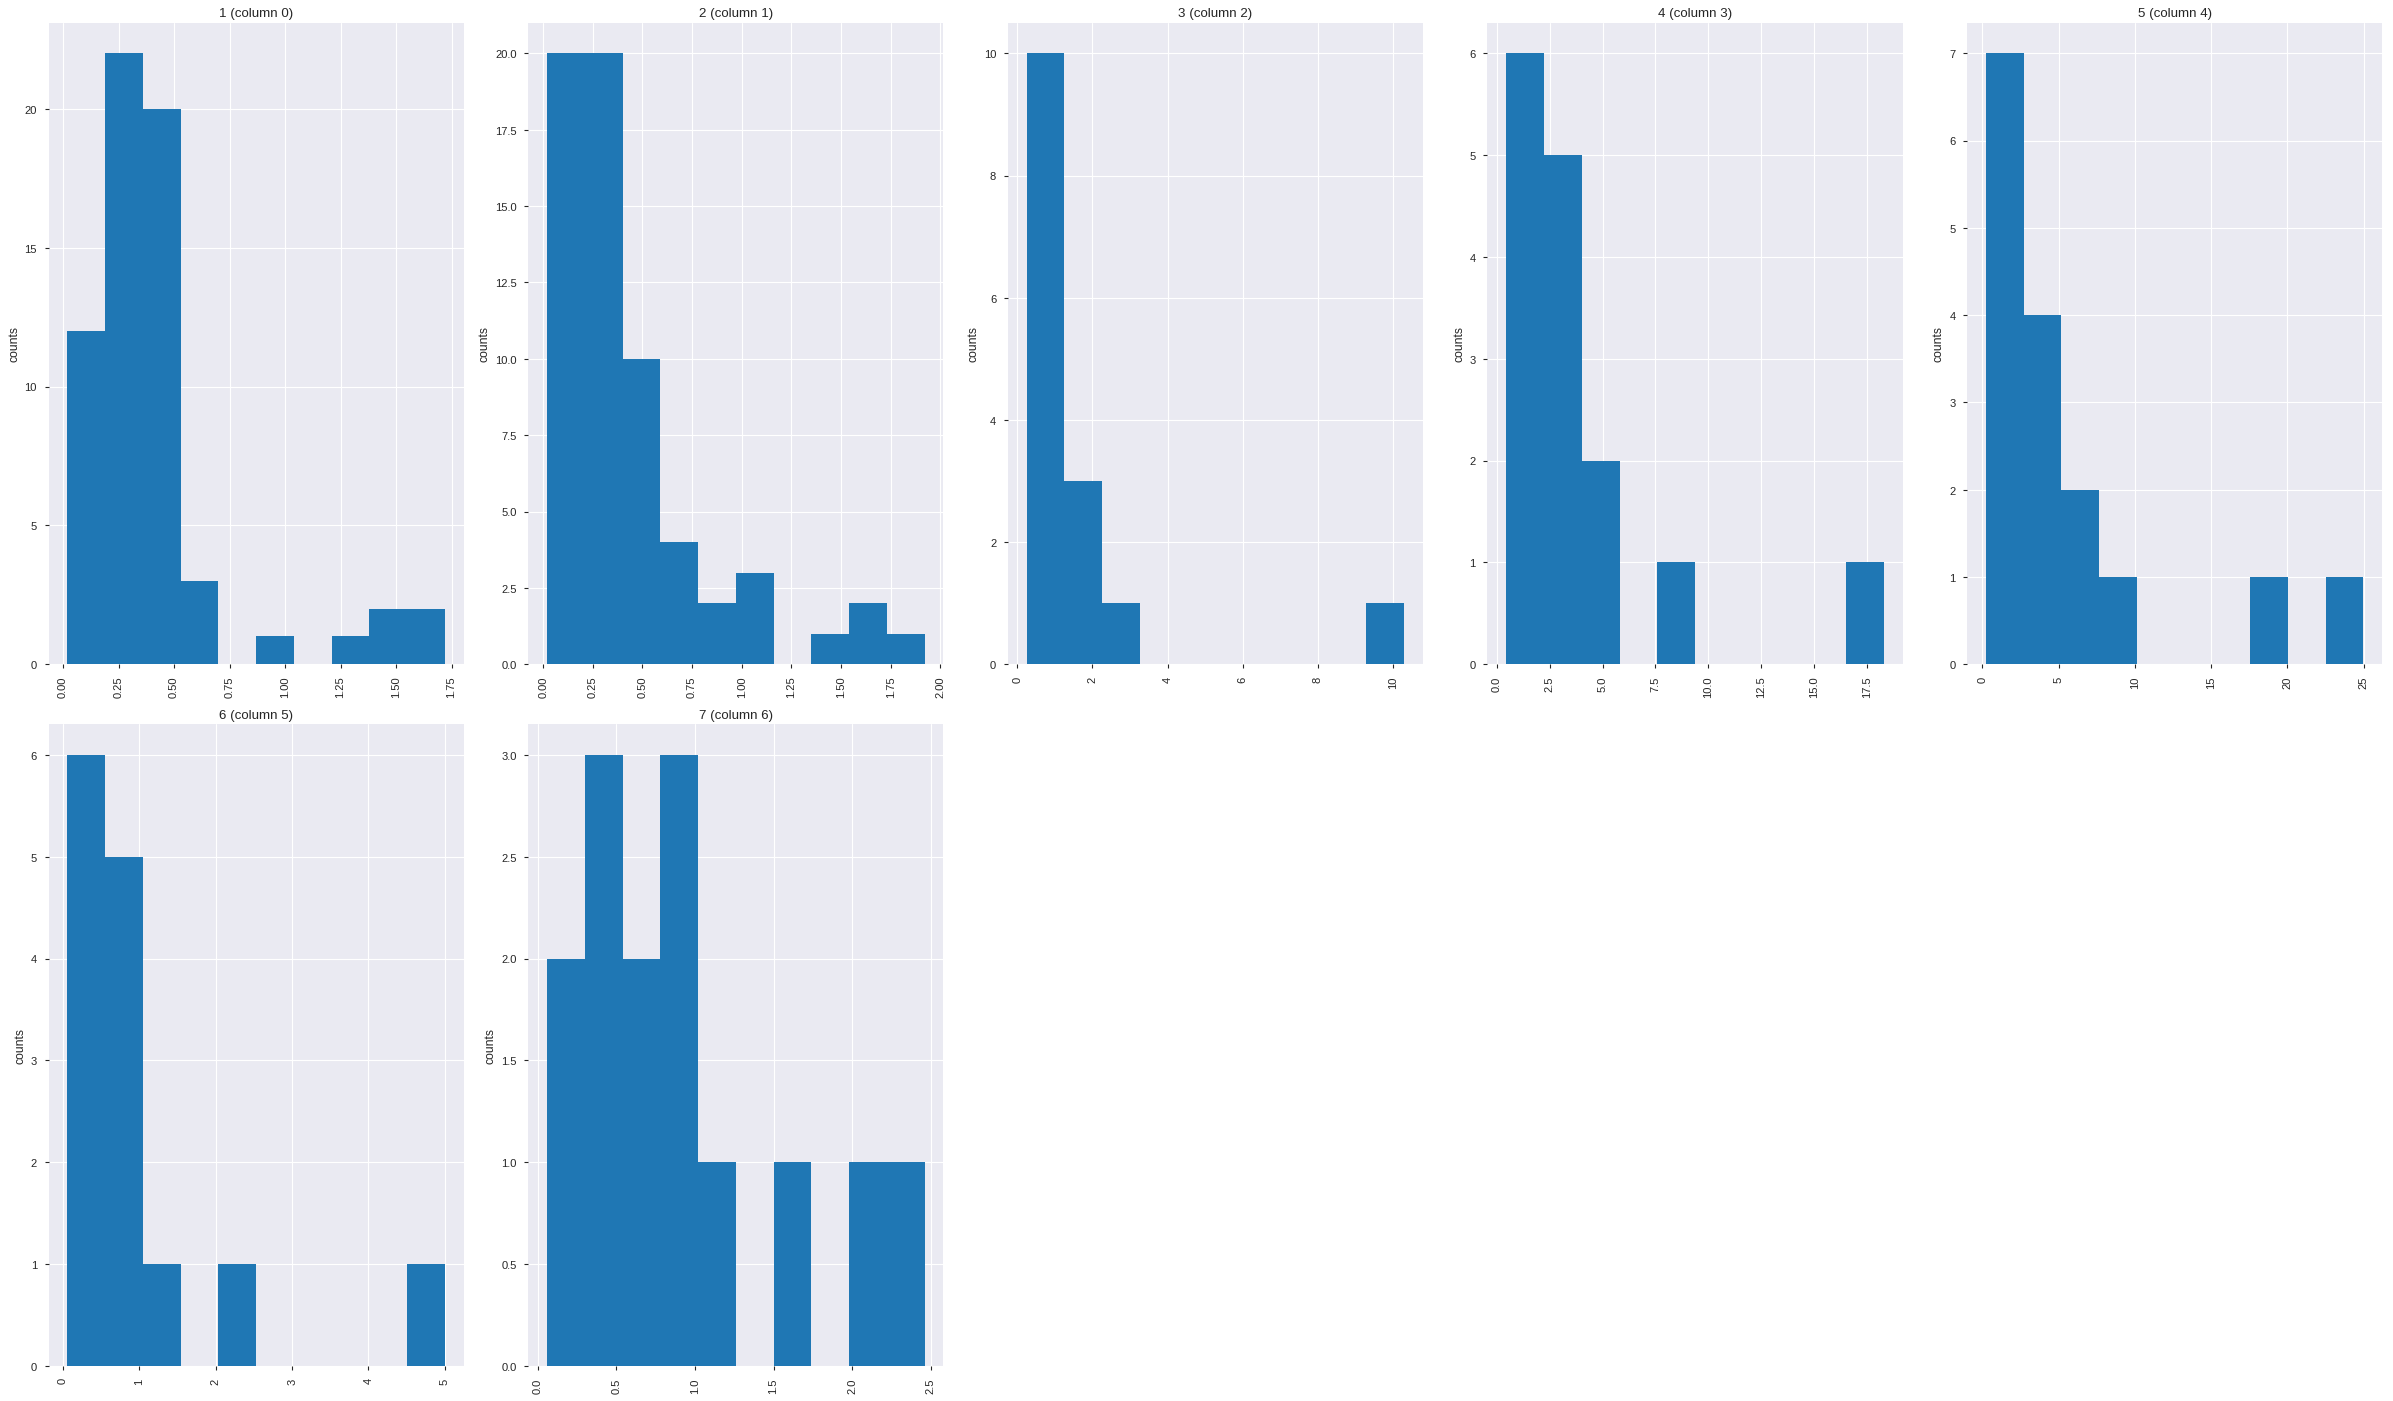

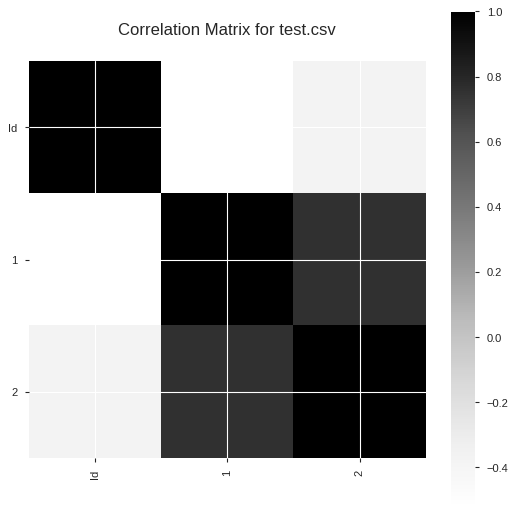

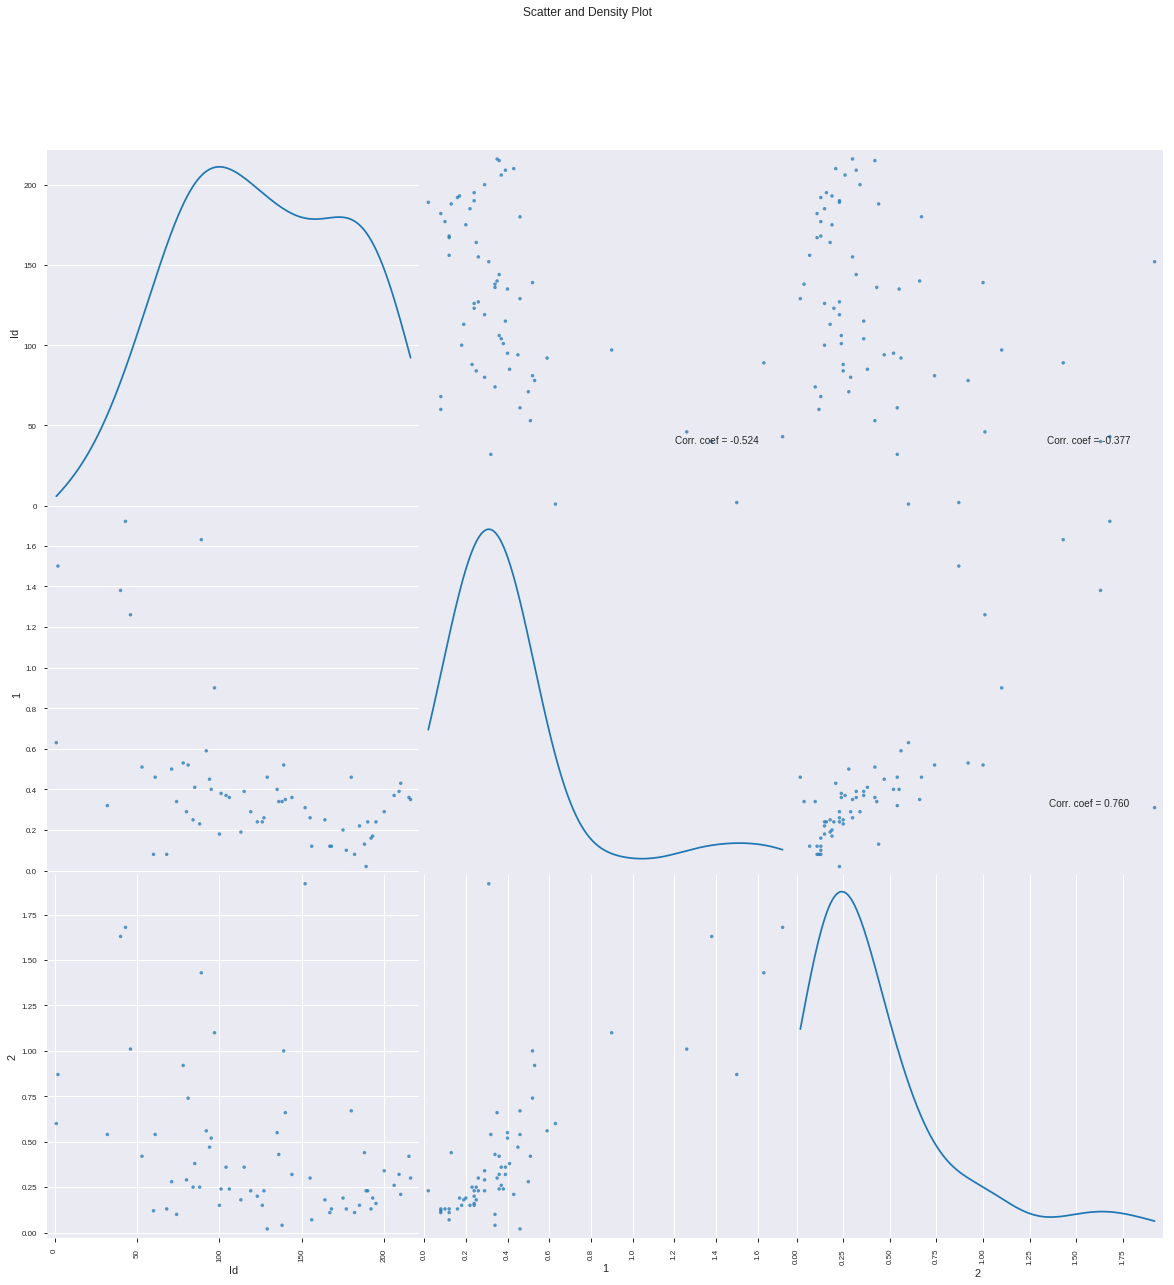

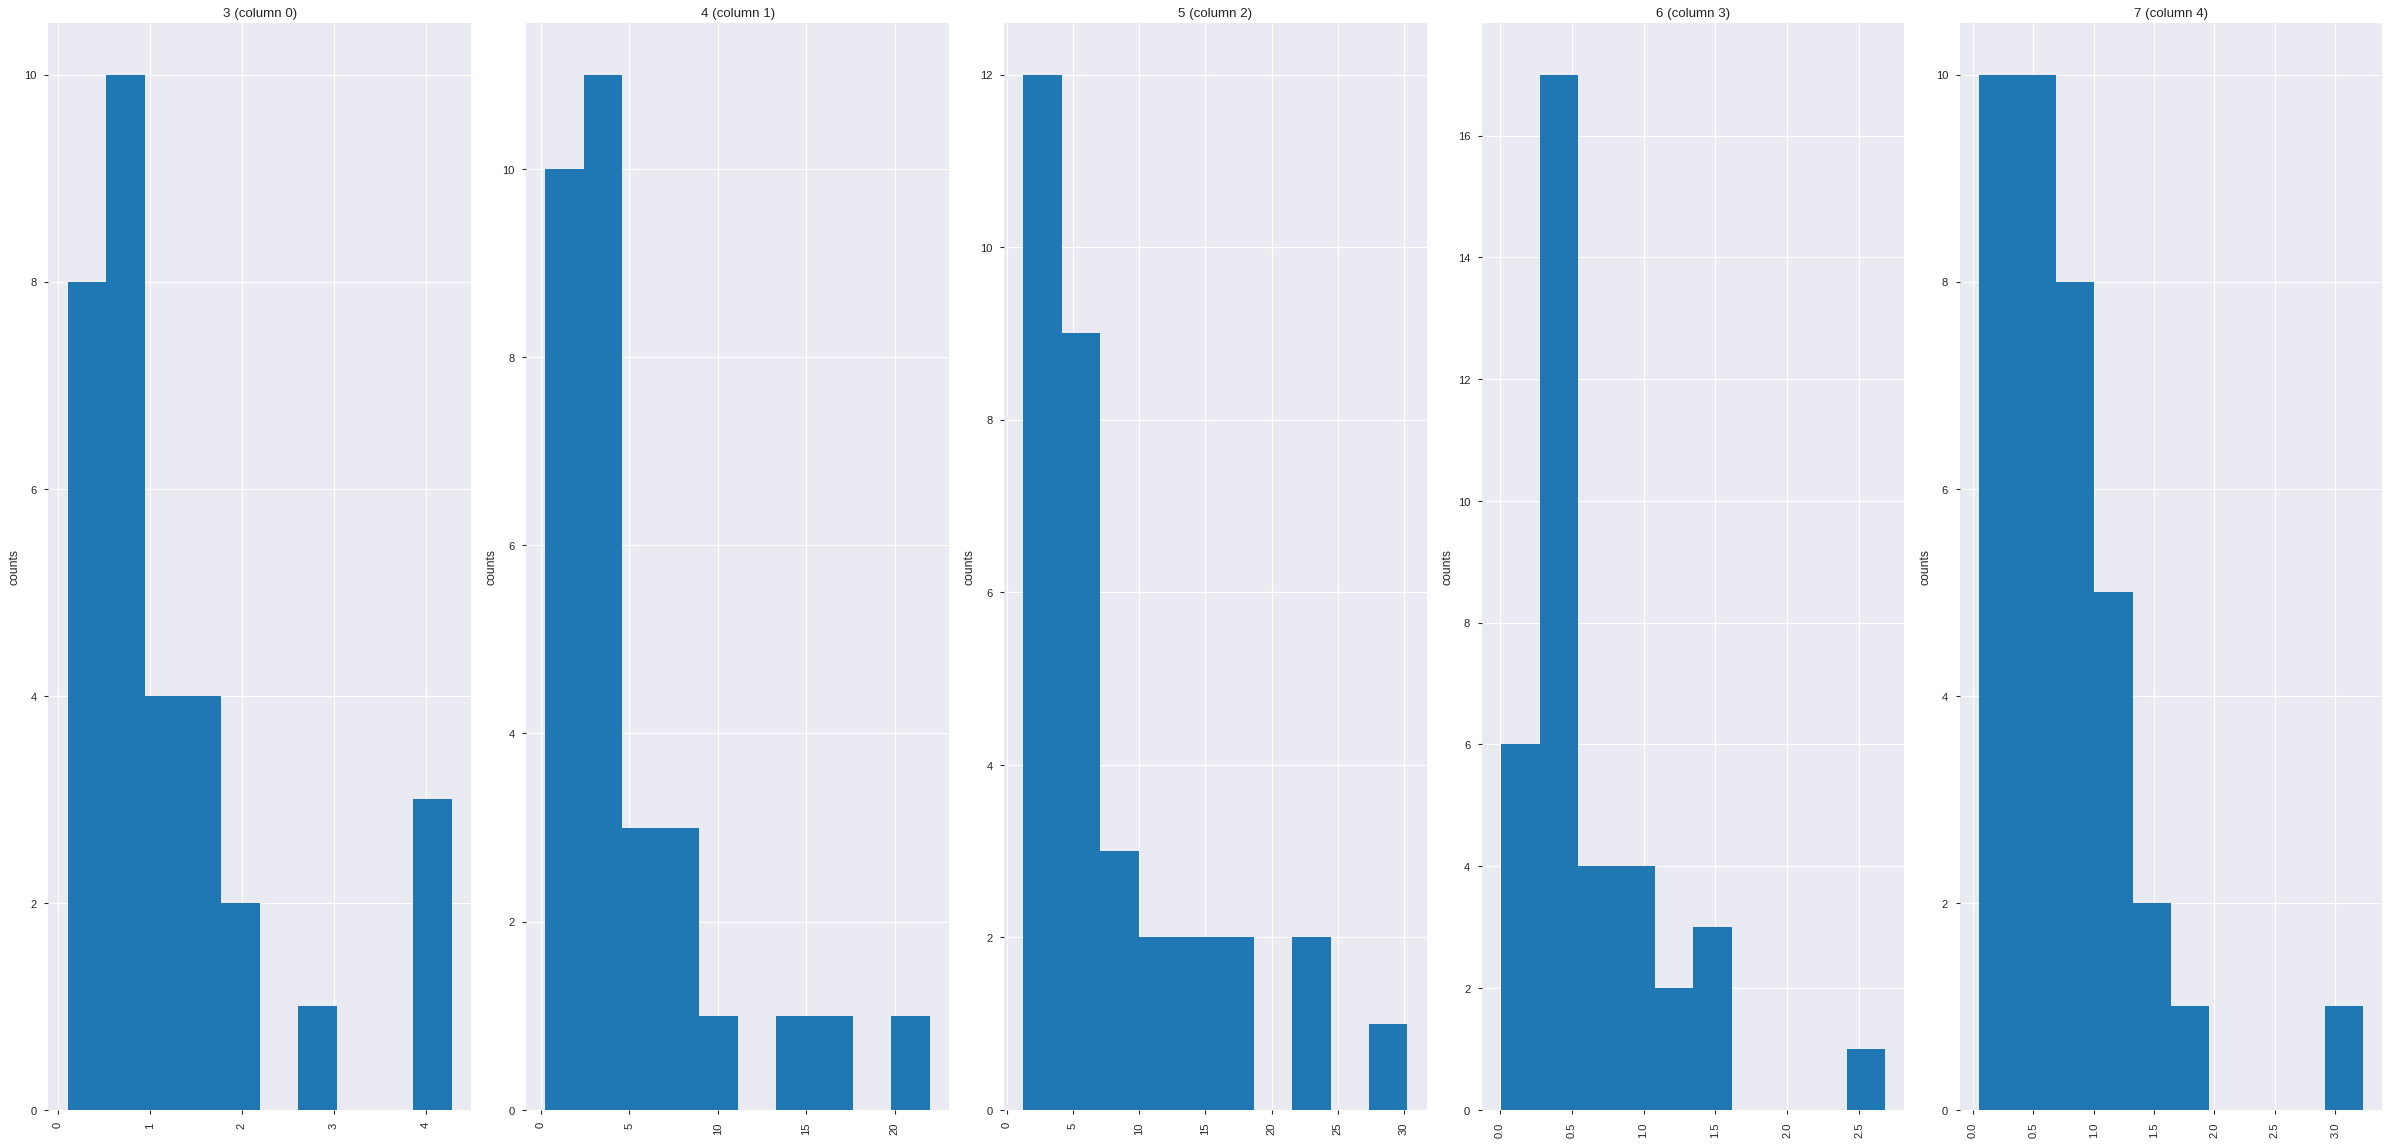

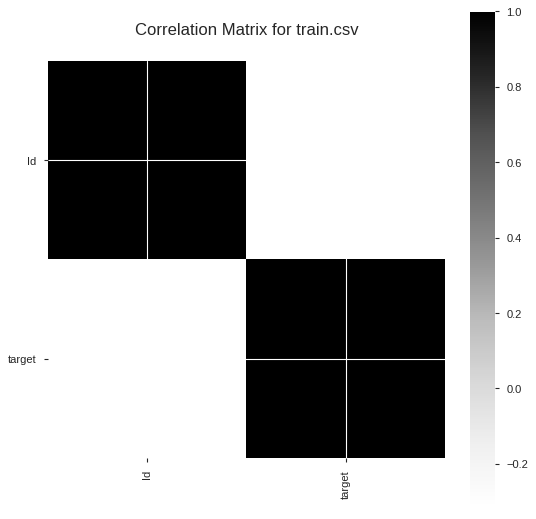

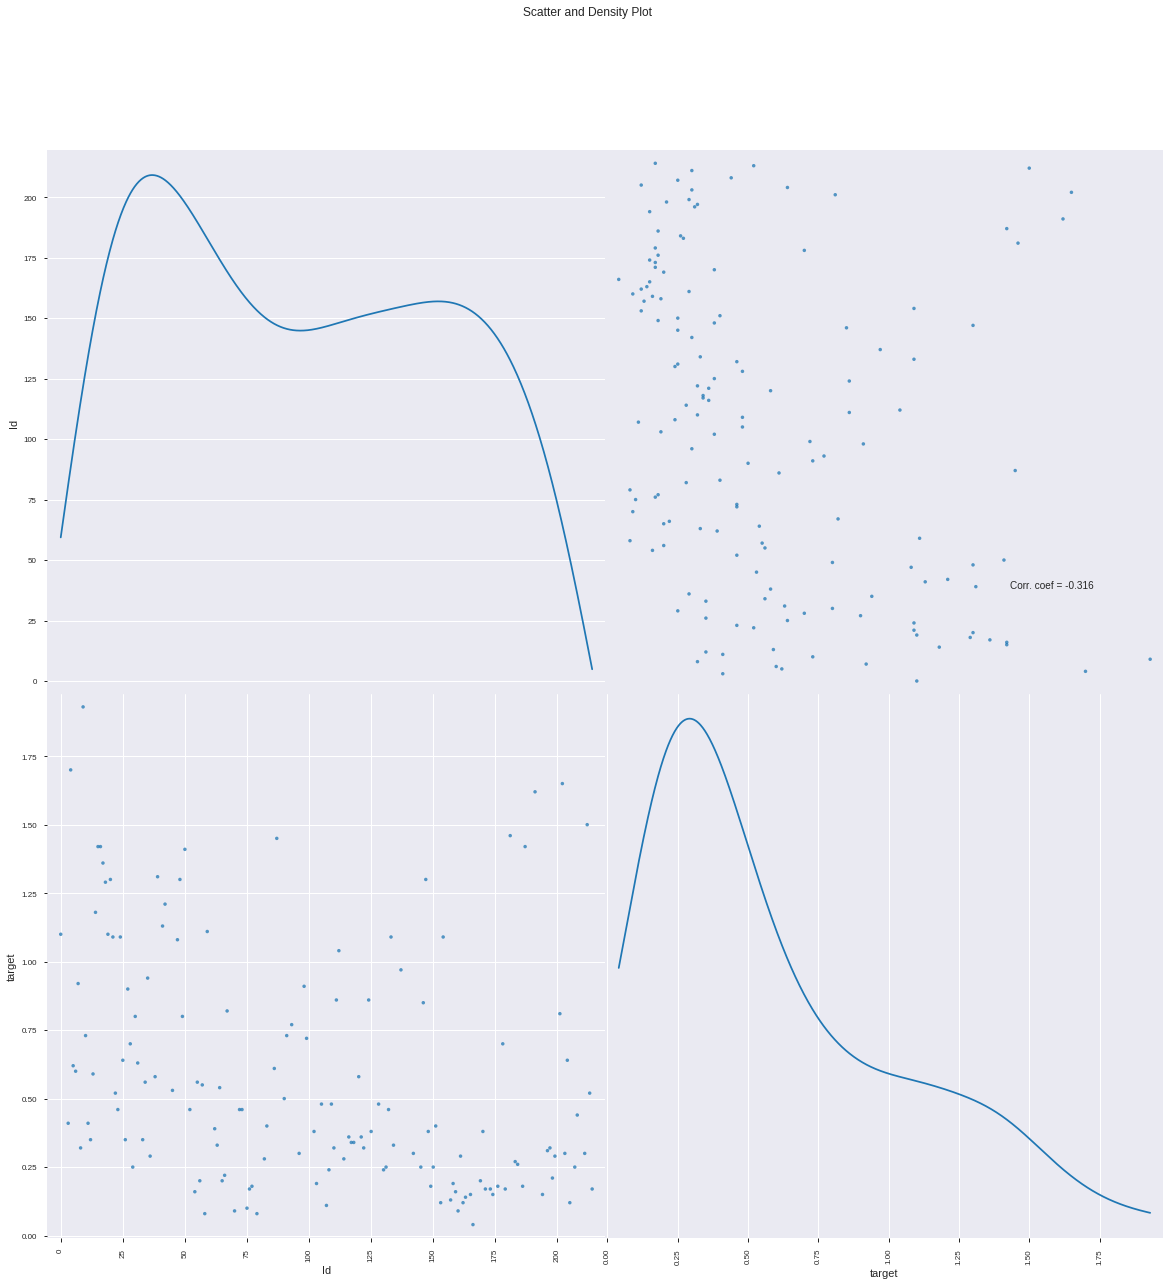

## 3. EDA <a class="anchor" id="3"></a>



This code is based on kernel "[FE & EDA with Pandas Profiling](https://www.kaggle.com/vbmokin/fe-eda-with-pandas-profiling)"

In [ ]:
pp.ProfileReport(train0)

In [ ]:
train0 = train0.drop(['Id','5','6','7'], axis = 1)
train0 = train0.dropna()
train0.info()

In [ ]:
train0.describe(percentiles = [.1, .9])

In [ ]:
train0.head(3)

## 4. Preparing to modeling <a class="anchor" id="4"></a>



In [ ]:
target_name = 'target'

In [ ]:
# For boosting model
train0b = train0
train_target0b = train0b[target_name]
train0b = train0b.drop([target_name], axis=1)
# Synthesis valid as test for selection models
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)

In [ ]:
train_target0 = train0[target_name]
train0 = train0.drop([target_name], axis=1)

In [ ]:
#For models from Sklearn
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [ ]:
train0.head(3)

In [ ]:
len(train0)

In [ ]:
# Synthesis valid as test for selection models
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [ ]:
train.head(3)

In [ ]:
test.head(3)

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [ ]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [ ]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [ ]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

## 5. Tuning models and test for all features <a class="anchor" id="5"></a>



### 5.1 XGB<a class="anchor" id="5.8"></a>



**XGBoost** is an ensemble tree method that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. XGBoost improves upon the base Gradient Boosting Machines (GBM) framework through systems optimization and algorithmic enhancements. Reference [Towards Data Science.](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

In [ ]:
xgb_clf = xgb.XGBRegressor({'objective': 'reg:squarederror'}) 
parameters = {'n_estimators': [60, 70, 80, 90, 95, 100, 105, 110, 120, 130, 140], 
              'learning_rate': [0.005, 0.01, 0.05, 0.075, 0.1],
              'max_depth': [3, 5, 7, 9],
              'reg_lambda': [0.1, 0.3, 0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(7,xgb_reg,trainb,testb)

### 5.2 LGBM <a class="anchor" id="5.9"></a>



**Light GBM** is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’. Reference [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/).

In [ ]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [ ]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=2000,verbose_eval=500, valid_sets=valid_set)

In [ ]:
acc_boosting_model(8,modelL,trainb,testb,modelL.best_iteration)

## 6. Models comparison <a class="anchor" id="6"></a>



We can now compare our models and to choose the best one for our problem.

In [ ]:
models = pd.DataFrame({
    'Model': ['XGB', 'LGBM'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:

models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

In [ ]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('graph for XGB and LGBM models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('%')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

In [ ]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for XGB and LGBM models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

In [ ]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('graph for XGB and LGBM models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('%')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

## 7. Prediction <a class="anchor" id="7"></a>


In [ ]:
testn = pd.read_csv('/kaggle/input/ammonium-prediction-in-river-water/test.csv')
testn.info()

In [ ]:
testn = testn.drop(['Id','5','6','7'], axis = 1)
testn.head(3)

In [ ]:
#For models from Sklearn
testn = pd.DataFrame(scaler.transform(testn), columns = testn.columns)

In [ ]:
#XGB model for basic train
xgb_reg.fit(train0, train_target0)
xgb_reg.predict(train)[:3]

[Go to Top](#0)